In [1]:
using AutomotiveDrivingModels
using AutoRisk
using AutoViz
using ForwardNets

In [2]:
##################################
# Constants
POLICY_FILEPATH = "/Users/wulfebw/Programming/gail-driver/julia/validation/models/gail_gru.h5"
N_FEATURES = 51;
# Constants
##################################

51

In [3]:
##################################
# Gaussian MLP Driver

type GaussianMLPDriver{A<:DriveAction, F<:Real, G<:Real, E<:AbstractFeatureExtractor, M<:MvNormal} <: DriverModel{A, IntegratedContinuous}
    net::ForwardNet
    rec::SceneRecord
    pass::ForwardPass
    input::Vector{F}
    output::Vector{G}
    extractor::E
    mvnormal::M
    context::IntegratedContinuous
end

_get_Σ_type{Σ,μ}(mvnormal::MvNormal{Σ,μ}) = Σ
function GaussianMLPDriver{A <: DriveAction}(::Type{A}, net::ForwardNet, extractor::AbstractFeatureExtractor, context::IntegratedContinuous;
    input::Symbol = :input,
    output::Symbol = :output,
    Σ::Union{Real, Vector{Float64}, Matrix{Float64},  Distributions.AbstractPDMat} = 0.1,
    rec::SceneRecord = SceneRecord(2, context.Δt),
    )

    pass = calc_forwardpass(net, [input], [output])
    input_vec = net[input].tensor
    output = net[output].tensor
    mvnormal = MvNormal(Array(Float64, 2), Σ)
    GaussianMLPDriver{A, eltype(input_vec), eltype(output), typeof(extractor), typeof(mvnormal)}(net, rec, pass, input_vec, output, extractor, mvnormal, context)
end
AutomotiveDrivingModels.get_name(::GaussianMLPDriver) = "GaussianMLPDriver"
AutomotiveDrivingModels.action_context(model::GaussianMLPDriver) = model.context

function AutomotiveDrivingModels.reset_hidden_state!(model::GaussianMLPDriver)
    empty!(model.rec)
    model
end

function temp_observe!{A,F,G,E,P}(model::GaussianMLPDriver{A,F,G,E,P},
                            scene::Scene, 
                            roadway::Roadway, 
                            egoid::Int)
    println("before update!")
    readline()
    update!(model.rec, scene)
    vehicle_index = get_index_of_first_vehicle_with_id(scene, egoid)
    println("before pull_features!")
    readline()
    o = pull_features!(model.extractor, model.rec, roadway, vehicle_index)
    model.net[:hidden_0].input = o
    println("before forward!")
    readline()
    forward!(model.pass)
    copy!(model.mvnormal.μ, model.output[1:2])

    model
end
Base.rand{A,F,G,E,P}(model::GaussianMLPDriver{A,F,G,E,P}) = convert(A, rand(model.mvnormal))
Distributions.pdf{A,F,G,E,P}(model::GaussianMLPDriver{A,F,G,E,P}, a::A) = pdf(model.mvnormal, convert(Vector{Float64}, a))
Distributions.logpdf{A,F,G,E,P}(model::GaussianMLPDriver{A,F,G,E,P}, a::A) = logpdf(model.mvnormal, convert(Vector{Float64}, a))
# Gaussian MLP Driver
######################################

In [4]:
##################################
# Feature Extractor
include("/Users/wulfebw/Programming/gail-driver/julia/pull_traces/multifeatureset.jl")

EXTRACT_CORE = true
EXTRACT_TEMPORAL = false
EXTRACT_WELL_BEHAVED = true
EXTRACT_NEIGHBOR_FEATURES = false
EXTRACT_CARLIDAR_RANGERATE = true
CARLIDAR_NBEAMS = 20
ROADLIDAR_NBEAMS = 0
ROADLIDAR_NLANES = 2
CARLIDAR_MAX_RANGE = 100.0
ROADLIDAR_MAX_RANGE = 100.0
test_extractor = MultiFeatureExtractor(
        EXTRACT_CORE,
        EXTRACT_TEMPORAL,
        EXTRACT_WELL_BEHAVED,
        EXTRACT_NEIGHBOR_FEATURES,
        EXTRACT_CARLIDAR_RANGERATE,
        CARLIDAR_NBEAMS,
        ROADLIDAR_NBEAMS,
        ROADLIDAR_NLANES,
        carlidar_max_range=CARLIDAR_MAX_RANGE,
        roadlidar_max_range=ROADLIDAR_MAX_RANGE,
);

# Feature Extractor
##################################

MultiFeatureExtractor(true,false,true,false,true,LidarSensor([-2.82743,-2.51327,-2.19911,-1.88496,-1.5708,-1.25664,-0.942478,-0.628319,-0.314159,0.0,0.314159,0.628319,0.942478,1.25664,1.5708,1.88496,2.19911,2.51327,2.82743,3.14159],[2.28638e-314,2.28638e-314,2.28638e-314,2.28638e-314,2.28638e-314,2.28638e-314,2.28638e-314,2.28638e-314,2.28638e-314,2.28638e-314,2.28638e-314,2.28638e-314,2.28638e-314,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[2.28638e-314,2.28638e-314,2.28638e-314,2.28638e-314,2.28638e-314,2.28638e-314,2.28638e-314,2.28638e-314,2.28638e-314,2.28638e-314,2.28638e-314,2.28638e-314,2.28638e-314,2.27382e-314,2.29574e-314,2.29574e-314,2.27382e-314,2.27382e-314,2.29574e-314,2.29574e-314],100.0,ConvexPolygon: len 0 (max 4 pts)
),RoadlineLidarSensor(Float64[],,100.0,ConvexPolygon: len 0 (max 4 pts)
),RoadwayLidarCulling(true,Inf,-Inf,Inf,-Inf,#undef,#undef,#undef,#undef,LanePortion[]))

In [5]:
#####################################
# Load Policy Functions
type Tim2DExtractor <: AbstractFeatureExtractor
    feature_means::Vector{Float64} # for standardization
    feature_std::Vector{Float64} # for standardization
    base_extractor::AbstractFeatureExtractor
    features::Vector{Float64}

    function Tim2DExtractor(filepath::AbstractString, base_extractor::AbstractFeatureExtractor)
        feature_means = vec(h5read(filepath, "initial_obs_mean")[1:N_FEATURES])
        feature_std = vec(h5read(filepath, "initial_obs_std")[1:N_FEATURES])
        features = zeros(size(feature_means))
        new(feature_means, feature_std, base_extractor, features)
    end
end

Base.length(::Tim2DExtractor) = N_FEATURES
_standardize(v::Real, μ::Real, σ::Real) = (v - μ)/σ
function temp_pull_features!{F<:AbstractFloat}(ext::Tim2DExtractor, rec::SceneRecord, roadway::Roadway, vehicle_index::Int)
    println("before base pull_features!")
    pull_features!(ext.base_extractor, ext.features, rec, roadway, vehicle_index)

    # standardize
    for (i,v) in enumerate(ext.features)
        ext.features[i] = _standardize(v, ext.feature_means[i], ext.feature_std[i])
    end
    ext.features
end

function _pull_W_b_h(filepath::AbstractString, path::AbstractString)
    W_xr = h5read(filepath, joinpath(path, "W_xr:0"))::Matrix{Float32}
    W_xu = h5read(filepath, joinpath(path, "W_xu:0"))::Matrix{Float32}
    W_xc = h5read(filepath, joinpath(path, "W_xc:0"))::Matrix{Float32}
    W_x = vcat(W_xr, W_xu, W_xc)
    
    W_hr = h5read(filepath, joinpath(path, "W_hr:0"))::Matrix{Float32}
    W_hu = h5read(filepath, joinpath(path, "W_hu:0"))::Matrix{Float32}
    W_hc = h5read(filepath, joinpath(path, "W_hc:0"))::Matrix{Float32}
    W_h = vcat(W_hr, W_hu, W_hc)
    
    b_r = h5read(filepath, joinpath(path, "b_r:0"))::Vector{Float32}
    b_u = h5read(filepath, joinpath(path, "b_u:0"))::Vector{Float32}
    b_c = h5read(filepath, joinpath(path, "b_c:0"))::Vector{Float32}
    b = vcat(b_r, b_u, b_c)
    
    (W_x, W_h, b)
end

function _pull_W_b(filepath::AbstractString, path::AbstractString)
    W = h5read(filepath, joinpath(path, "W:0"))::Matrix{Float32}
    b = h5read(filepath, joinpath(path, "b:0"))::Vector{Float32}
    (W,b)
end

function load_gru_driver(
            filepath::AbstractString = POLICY_FILEPATH, 
            iteration::Int=-1; 
            gru_layer::Bool=true,
            bc_policy::Bool=false,
            action_type::DataType=AccelTurnrate)

    if iteration == -1 # load most recent
        fid = h5open(filepath)
        for val in keys(read(fid))
            i = parse(Int, match(r"\d+", val).match)
            iteration = max(iteration, i)
        end
    end

    if gru_layer
        basepath = @sprintf("iter%05d/mlp_policy", iteration)
        layers = sort(collect(keys(h5read(filepath, basepath))))
        layers = layers[1:end-1]
    else
        if bc_policy
            basepath = @sprintf("iter%05d/mlp_policy", iteration)
            layers = sort(collect(keys(h5read(filepath, basepath))))
            layers = layers[1:end-2]
        else
            basepath = @sprintf("iter%05d/mlp_policy/mean_network", iteration)
            layers = sort(collect(keys(h5read(filepath, basepath))))
            layers = layers[1:end-1]
        end
    end
    

    W, b = _pull_W_b(filepath, joinpath(basepath, layers[1]))

    net = ForwardNet{Float32}()
    push!(net, Variable(:input, Array(Float32, size(W, 2))))

    # hidden layers
    for layer in layers
        layer_sym = Symbol(layer)
        W, b = _pull_W_b(filepath, joinpath(basepath, layer))
        push!(net, Affine, layer_sym, lastindex(net), size(W, 1))
        copy!(net[layer_sym].W, W)
        copy!(net[layer_sym].b, b)
        push!(net, ELU, Symbol(layer*"ELU"), lastindex(net))
    end
    # Add GRU layer
    if gru_layer
        # output layer
        W, b = _pull_W_b(filepath, joinpath(basepath, "output"))
        push!(net, Affine, :output_layer_mlp, lastindex(net), size(W, 1))
        copy!(net[:output_layer_mlp].W, W)
        copy!(net[:output_layer_mlp].b, b)
        push!(net, Variable(:output_mlp, output(net[:output_layer_mlp])), lastindex(net))
        push!(net, ELU, Symbol("output_ELU"), lastindex(net))

        basepath = @sprintf("iter%05d/gru_policy", iteration)
        W_x, W_h, b = _pull_W_b_h(filepath, joinpath(basepath, "mean_network", "gru"))
        push!(net, GRU, :gru, :output_mlp, size(W_h, 2))
        copy!(net[:gru].W_x, W_x)
        copy!(net[:gru].W_h, W_h)
        copy!(net[:gru].b, b)
        copy!(net[:gru].h_prev, zeros(size(W_h, 2)))
        push!(net, Variable(:output_gru, output(net[:gru])), lastindex(net))

        # Finally, output layer from GRU
        W, b = _pull_W_b(filepath, joinpath(basepath, "mean_network", "output_flat"))
        push!(net, Affine, :output_layer, :gru, size(W, 1))
        copy!(net[:output_layer].W, W)
        copy!(net[:output_layer].b, b)
        push!(net, Variable(:output, output(net[:output_layer])), lastindex(net))
    else
        # Output layer
        if bc_policy
            W, b = _pull_W_b(filepath, joinpath(basepath, "mean_network", "output_flat"))
        else
            W, b = _pull_W_b(filepath, joinpath(basepath, "output"))
        end
        push!(net, Affine, :output_layer, lastindex(net), size(W, 1))
        copy!(net[:output_layer].W, W)
        copy!(net[:output_layer].b, b)
        push!(net, Variable(:output, output(net[:output_layer])), lastindex(net))
        basepath = @sprintf("iter%05d/mlp_policy", iteration)
    end
    if gru_layer
        logstdevs = vec(h5read(filepath, joinpath(basepath, "output_log_std/param:0")))::Vector{Float32}
    else
        if bc_policy
            logstdevs = vec(h5read(filepath, joinpath(basepath, "output_log_std/param:0")))::Vector{Float32}
        else
            logstdevs = vec(h5read(filepath, joinpath(basepath, "output_std_param/param:0")))::Vector{Float32}
        end
    end
    Σ = convert(Vector{Float64}, exp(logstdevs))
    Σ = Σ.^2

    # extactor
    base_extractor = MultiFeatureExtractor(
        EXTRACT_CORE,
        EXTRACT_TEMPORAL,
        EXTRACT_WELL_BEHAVED,
        EXTRACT_NEIGHBOR_FEATURES,
        EXTRACT_CARLIDAR_RANGERATE,
        CARLIDAR_NBEAMS,
        ROADLIDAR_NBEAMS,
        ROADLIDAR_NLANES,
        carlidar_max_range=CARLIDAR_MAX_RANGE,
        roadlidar_max_range=ROADLIDAR_MAX_RANGE,
    )
    extractor = Tim2DExtractor(POLICY_FILEPATH, base_extractor)

    GaussianMLPDriver(action_type, net, extractor, IntegratedContinuous(0.1,1),
                        input = :input, output = :output, Σ = Σ)
end;

# Load Policy Functions
#####################################

load_gru_driver (generic function with 3 methods)

In [6]:
##################################
# Simulation
function AutomotiveDrivingModels.get_actions!{A<:DriveAction, D<:DriverModel}(
    actions::Vector{A},
    scene::Scene,
    roadway::Roadway,
    models::Dict{Int, D}, # id → model
    )


    for (veh_i,veh) in enumerate(scene)
        model = models[veh.def.id]
#         println("before observe! veh id: $(veh.def.id)")
#         readline()
#         println(typeof(model))
        if veh.def.id == 2
#             println("temp observe")
#             println("before update!")
#             readline()
            AutomotiveDrivingModels.update!(model.rec, scene)
            vehicle_index = get_index_of_first_vehicle_with_id(scene, veh.def.id)
#             println("before pull_features!")
#             readline()
 
            ext = model.extractor
            pull_features!(ext.base_extractor, ext.features, model.rec, roadway, vehicle_index)
            for (i,v) in enumerate(ext.features)
                ext.features[i] = _standardize(v, ext.feature_means[i], ext.feature_std[i])
            end
            ext.features
#             println(ext.features)
#             println(size(ext.features))
#             readline()
            model.net[:hidden_0].input = ext.features[1:45]
#             println("before forward!")
#             readline()
            forward!(model.pass)
            copy!(model.mvnormal.μ, model.output[1:2])
        else
#             println("normal observe")
            AutomotiveDrivingModels.observe!(model, scene, roadway, veh.def.id)
        end
        veh_actions = rand(model)
#         println(veh_actions)

        
        if veh.def.id == 2
            a = min(max(veh_actions.a, -5.), 3.)
            ω = min(max(veh_actions.ω, -.1), .1)
            veh_actions = AccelTurnrate(a, ω)
        end
        actions[veh_i] = veh_actions
    end

    actions
end
function simulate!(scene::Scene, models::Dict{Int, DriverModel},
        roadway::Roadway, rec::SceneRecord, T::Float64)
    actions = Array(DriveAction, length(scene))

    # simulate for T seconds in rec.timestep-length substeps
    for t in 0:rec.timestep:(T - rec.timestep)
#         println("before get_actions!")
#         readline()
        get_actions!(actions, scene, roadway, models)
#         println("before tick!")
#         readline()
        tick!(scene, roadway, actions, models)
#         println("before update!")
#         readline()
        AutomotiveDrivingModels.update!(rec, scene)
    end
    return rec
end
# Simulation
##################################

simulate! (generic function with 1 method)

In [7]:
##################################
# Scene Building
context = IntegratedContinuous(.1, 1)
num_veh = 2
roadway = gen_straight_roadway(2, 100.)
models = Dict{Int, DriverModel}()
scene = Scene(num_veh)
rec = SceneRecord(100, .1, num_veh)

# single car in front
road_idx = RoadIndex(proj(VecSE2(0.0, 0.0, 0.0), roadway))
road_pos = 10.
base_speed = 8.
veh_state = VehicleState(Frenet(road_idx, roadway), roadway, base_speed)
veh_state = move_along(veh_state, roadway, road_pos)
veh_def = VehicleDef(1, AgentClass.CAR, 5., 2.)
push!(scene, Vehicle(veh_state, veh_def))
    
# gail driver behind
gail_id = 2
veh_state = VehicleState(Frenet(road_idx, roadway), roadway, base_speed)
veh_def = VehicleDef(gail_id, AgentClass.CAR, 5., 2.)
push!(scene, Vehicle(veh_state, veh_def))

# build models
mlon = StaticLongitudinalDriver(0.)
models[1] = Tim2DDriver(context, mlon = mlon)

iteration = 300
driver = load_gru_driver(POLICY_FILEPATH, iteration,)
models[2] = driver;
# Scene Building
##################################

GaussianMLPDriver{AutomotiveDrivingModels.AccelTurnrate,Float32,Float32,Tim2DExtractor,Distributions.MvNormal{Float64,PDMats.PDiagMat{Float64,Array{Float64,1}},Array{Float64,1}}}(ForwardNets.ForwardNet{Float32}({16, 15} directed graph,ForwardNets.Node{Float32}[ForwardNets.Variable{Float32,1}(:input,Float32[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  1.4013f-45,8.2289f-24,1.4013f-45,8.22901f-24,1.4013f-45,8.228f-24,1.4013f-45,8.22911f-24,1.4013f-45,8.22921f-24]),ForwardNets.Affine{Float32}(:hidden_0,Float32[0.0582158 0.0177425 … -0.122517 0.123201; 0.0355753 0.182766 … 0.154744 0.102356; … ; -0.12347 -0.00600129 … 0.0712935 -0.00663651; -0.0214794 0.0355152 … -0.126224 0.143394],Float32[-0.000299859,0.00343914,0.00182253,0.000270366,0.00140208,-0.00484741,-0.00172104,0.00123221,0.00382252,0.00172661  …  0.000119726,0.000601371,0.000529396,-0.000456787,0.00424507,-0.000636135,-0.000333571,-0.00144169,0.000445658,-0.00482369],Float32[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  1.4013f-45,

In [8]:
##################################
# Run
T = 10.
simulate!(scene, models, roadway, rec, T);
# Run
##################################

AutomotiveDrivingModels.Tim2DDriver
GaussianMLPDriver{AutomotiveDrivingModels.AccelTurnrate,Float32,Float32,Tim2DExtractor,Distributions.MvNormal{Float64,PDMats.PDiagMat{Float64,Array{Float64,1}},Array{Float64,1}}}
AutomotiveDrivingModels.Tim2DDriver
GaussianMLPDriver{AutomotiveDrivingModels.AccelTurnrate,Float32,Float32,Tim2DExtractor,Distributions.MvNormal{Float64,PDMats.PDiagMat{Float64,Array{Float64,1}},Array{Float64,1}}}
AutomotiveDrivingModels.Tim2DDriver
GaussianMLPDriver{AutomotiveDrivingModels.AccelTurnrate,Float32,Float32,Tim2DExtractor,Distributions.MvNormal{Float64,PDMats.PDiagMat{Float64,Array{Float64,1}},Array{Float64,1}}}
AutomotiveDrivingModels.Tim2DDriver
GaussianMLPDriver{AutomotiveDrivingModels.AccelTurnrate,Float32,Float32,Tim2DExtractor,Distributions.MvNormal{Float64,PDMats.PDiagMat{Float64,Array{Float64,1}},Array{Float64,1}}}
AutomotiveDrivingModels.Tim2DDriver
GaussianMLPDriver{AutomotiveDrivingModels.AccelTurnrate,Float32,Float32,Tim2DExtractor,Distributions.MvN

SceneRecord(nscenes=100)

Interact.Options{:SelectionSlider,Int64}(Signal{Int64}(-50, nactions=1),"pastframe",-50,"-50",Interact.OptionDict(DataStructures.OrderedDict("-99"=>-99,"-98"=>-98,"-97"=>-97,"-96"=>-96,"-95"=>-95,"-94"=>-94,"-93"=>-93,"-92"=>-92,"-91"=>-91,"-90"=>-90…),Dict(-98=>"-98",-91=>"-91",-90=>"-90",-74=>"-74",-80=>"-80",-77=>"-77",-7=>"-7",-32=>"-32",-3=>"-3",-56=>"-56"…)),Any[],Any[],true,"horizontal")

Interact.Options{:ToggleButtons,Float64}(Signal{Float64}(1.0, nactions=1),"zoom",1.0,"1.0",Interact.OptionDict(DataStructures.OrderedDict("1.0"=>1.0,"2.0"=>2.0,"3.0"=>3.0,"4.0"=>4.0,"5.0"=>5.0,"6.0"=>6.0,"7.0"=>7.0,"8.0"=>8.0,"9.0"=>9.0,"10.0"=>10.0…),Dict(7.0=>"7.0",4.0=>"4.0",9.0=>"9.0",10.0=>"10.0",2.0=>"2.0",3.0=>"3.0",5.0=>"5.0",8.0=>"8.0",6.0=>"6.0",1.0=>"1.0"…)),Any[],Any[],true,"horizontal")

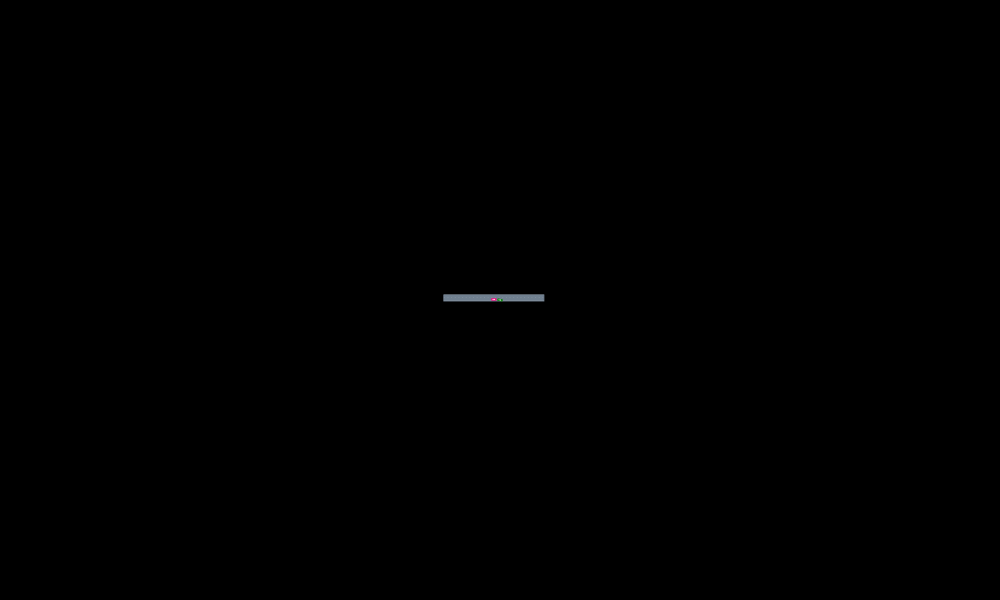

In [9]:
##################################
# Viz
@manipulate for pastframe in (-length(rec)+1) : 0,
    zoom in collect(1:10.)
    render(get!(scene, rec, pastframe), roadway, cam=CarFollowCamera(gail_id, zoom), 
       car_colors=Dict{Int,Colorant}(gail_id=>colorant"green"))
end
# Viz
##################################